In [39]:
import pysam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# test
data_test_path = 'data/test/'
df1 = f'{data_test_path}test_1.fastq'
df2 = f'{data_test_path}test_2.fastq'
# genome = f'{data_test_path}MG1655-K12.first10K.fasta'

# prod
data_path = 'data/E.coli/'
df1_1 = f'{data_path}100x.1.fastq'
df1_2 = f'{data_path}100x.2.fastq'
df2_1 = f'{data_path}ecoli_mda_lane1_left.downsampled.fastq'
df2_2 = f'{data_path}ecoli_mda_lane1_right.downsampled.fastq'
genome = f'{data_path}MG1655-K12.fasta'

# 0. Разбораться с bwa mem

Будем использовать bwa mem

Построим индекс:

In [170]:
!bwa index {genome}

[bwa_index] Pack FASTA... 0.04 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 1.14 seconds elapse.
[bwa_index] Update BWT... 0.02 sec
[bwa_index] Pack forward-only FASTA... 0.02 sec
[bwa_index] Construct SA from BWT and Occ... 0.27 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index data/E.coli/MG1655-K12.fasta
[main] Real time: 1.506 sec; CPU: 1.512 sec


Строим выравнивание:

In [ ]:
!bwa mem {genome} {df1_1} {df1_2} > {data_path}alignment1.sam

In [ ]:
!bwa mem {genome} {df2_1} {df2_2} > {data_path}alignment2.sam

Определяем процент приложившихся ридов:

In [46]:
!samtools flagstat {data_path}alignment1.sam

5000581 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
581 + 0 supplementary
0 + 0 duplicates
4991553 + 0 mapped (99.82% : N/A)
5000000 + 0 paired in sequencing
2500000 + 0 read1
2500000 + 0 read2
4978334 + 0 properly paired (99.57% : N/A)
4983734 + 0 with itself and mate mapped
7238 + 0 singletons (0.14% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [47]:
!samtools flagstat {data_path}alignment2.sam

5869326 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
40560 + 0 supplementary
0 + 0 duplicates
5706946 + 0 mapped (97.23% : N/A)
5828766 + 0 paired in sequencing
2914383 + 0 read1
2914383 + 0 read2
5151500 + 0 properly paired (88.38% : N/A)
5647486 + 0 with itself and mate mapped
18900 + 0 singletons (0.32% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


99.82% ридов приложилось для 1 датасета

97.23% ридов приложилось для 2 датасета

# 1. Покрытие генома

Превратим sam файл в bam, отсортируем и проиндексируем его 

In [48]:
!samtools view -b {data_path}alignment1.sam > {data_path}alignment1.bam
!samtools sort {data_path}alignment1.bam > {data_path}alignment1.sorted.bam
!samtools index {data_path}alignment1.sorted.bam

!samtools view -b {data_path}alignment2.sam > {data_path}alignment2.bam
!samtools sort {data_path}alignment2.bam > {data_path}alignment2.sorted.bam
!samtools index {data_path}alignment2.sorted.bam

[bam_sort_core] merging from 1 files and 1 in-memory blocks...
[bam_sort_core] merging from 2 files and 1 in-memory blocks...


Посчитаем покрытие

Доля покрытой области: 100.0 %
Среднее покрытие: 508.9747


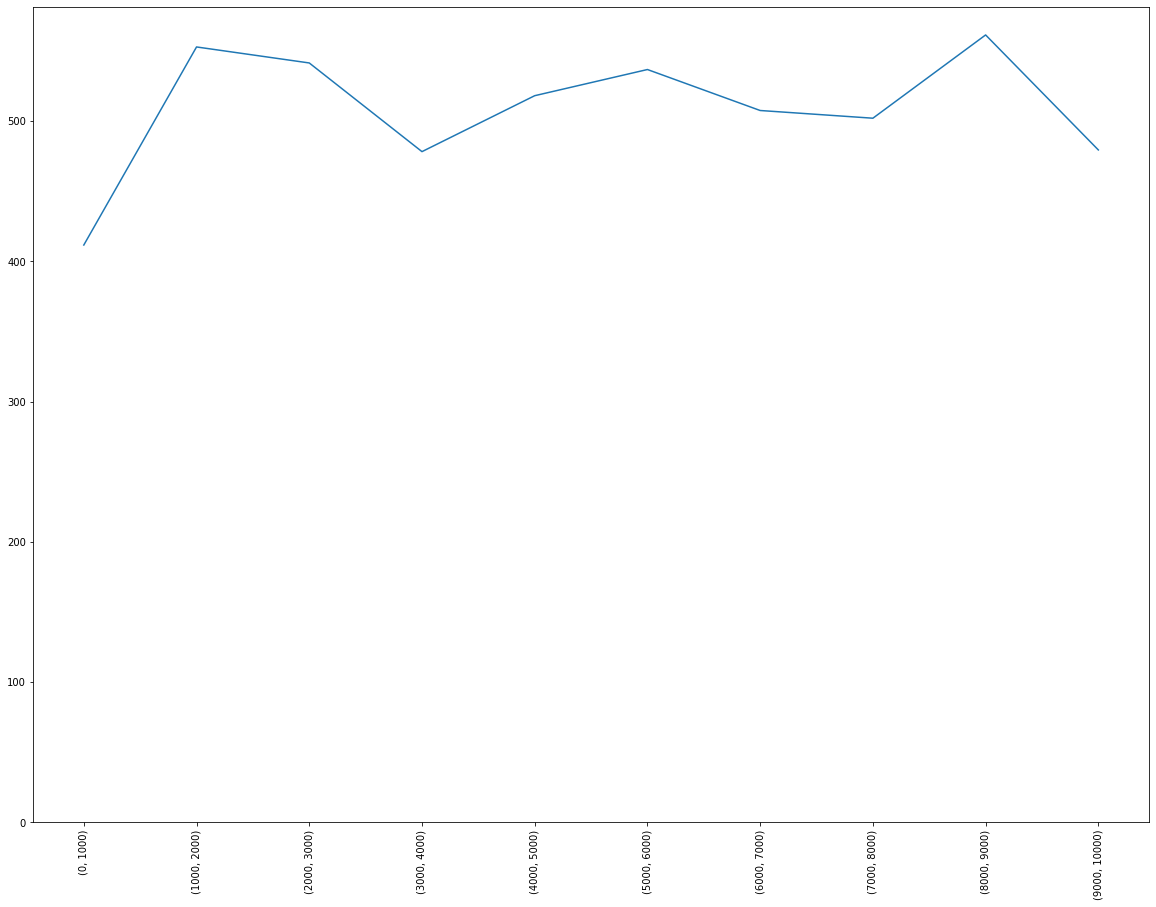

Доля покрытой области: 99.99989223383103 %
Среднее покрытие: 105.23073426479225


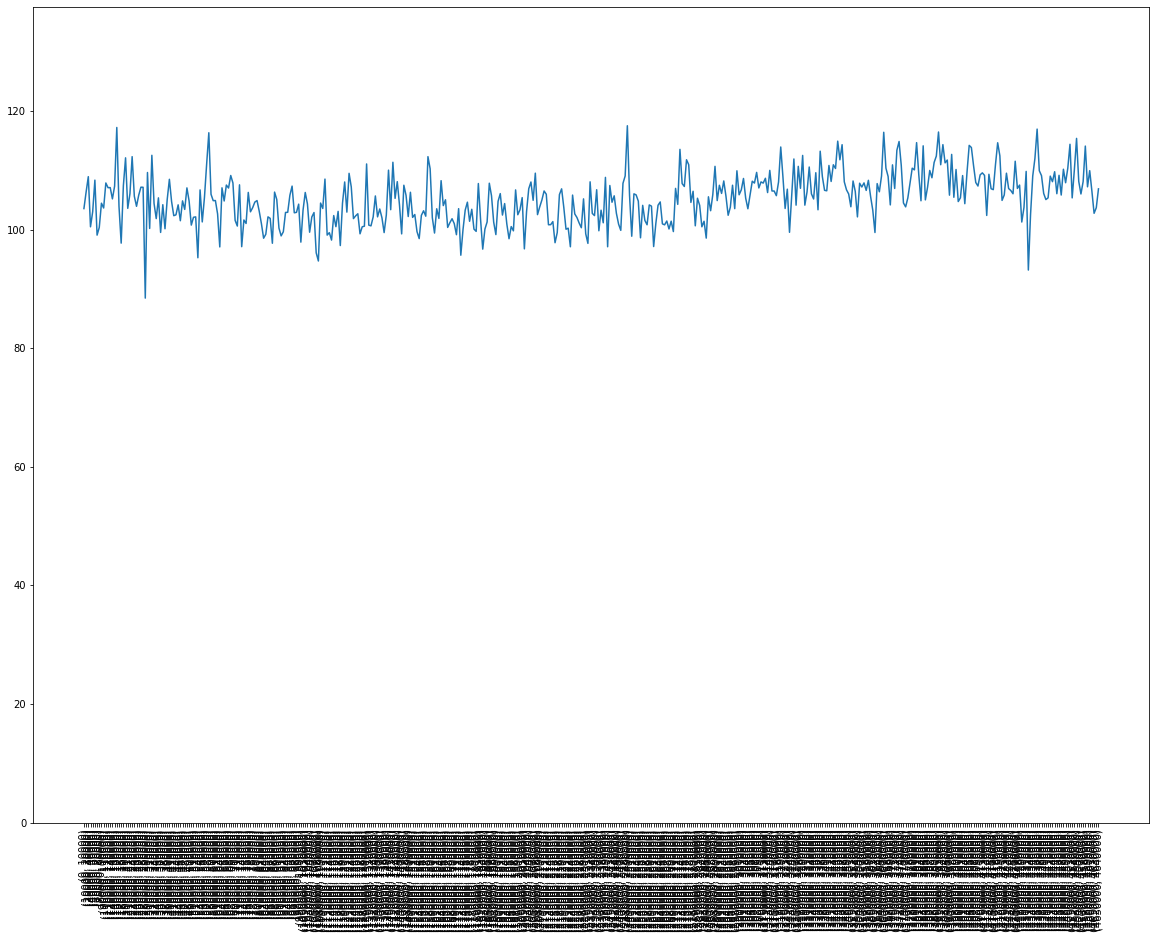

Доля покрытой области: 96.53824890752047 %
Среднее покрытие: 119.3751894259835


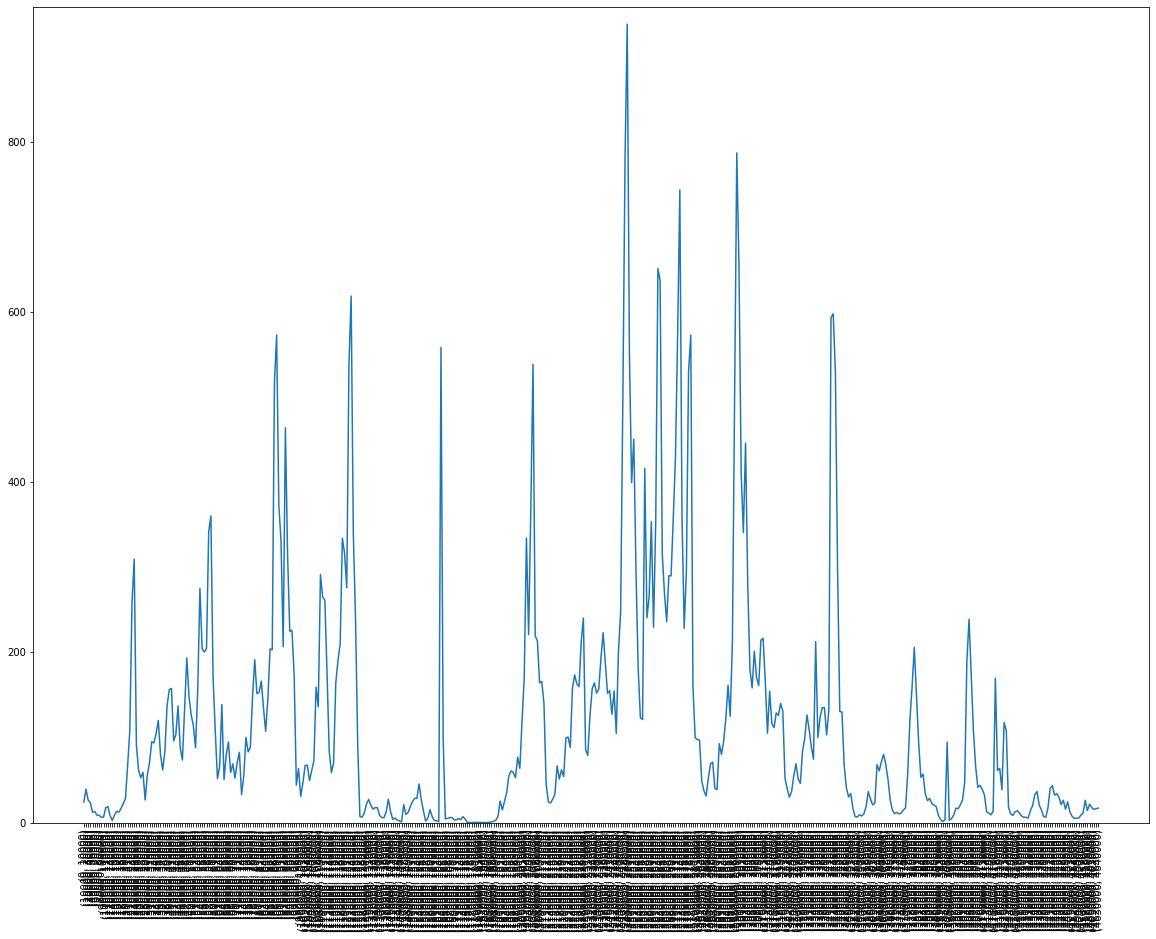

In [40]:
def coverage(al_path, avg=1000):
    bamfile = pysam.AlignmentFile(al_path, 'rb')
    ref_name = bamfile.get_reference_name(0)
    ref_len = bamfile.get_reference_length(ref_name)
    
    pos_cov = np.array([0] * ref_len)
    
    for line in bamfile:
        blocks = line.get_blocks()
        if len(blocks) > 0:
            for cov in blocks:
                pos_cov[cov[0]: cov[1]] += 1
    
    pos_cov_avg = []
    pos_cov_avg_lab = []
    
    for i in range(0, len(pos_cov), avg):
        pos_cov_avg_lab.append(f'({i}, {i + avg})')
        pos_cov_avg.append(pos_cov[i: i + avg].mean())
    
    cov_prop = len(pos_cov[pos_cov != 0]) / len(pos_cov)
    cov_mean = pos_cov.mean()
    
    print('Доля покрытой области:', cov_prop * 100, '%')
    print('Среднее покрытие:', cov_mean)
    
    plt.figure(figsize=(20, 15))
    plt.plot(pos_cov_avg_lab, pos_cov_avg)
    plt.xticks(rotation='vertical')
    plt.ylim([0, max(pos_cov_avg) + 20])
    plt.show()

# запускаем на тестовых данных и двух датасетах
coverage(f'{data_test_path}alignment.sorted.bam')
coverage(f'{data_path}alignment1.sorted.bam', avg=10000)
coverage(f'{data_path}alignment2.sorted.bam', avg=10000)

# 2. Распределение расстояния вставки

среднее расстояние вставки: 215.2860440340909
среднеквадратичное отклонение: 10.590040942453138
интервал минимальной ширины, в который попадает 95% ридов: (195, 233)
среднее расстояние вставки 95% ридов: 214.96881394467601
среднеквадратичное отклонение 95% ридов: 8.842843564104365


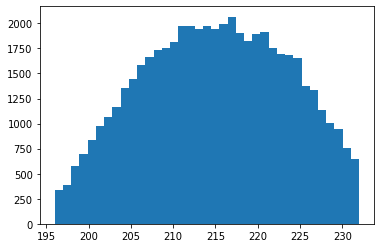

среднее расстояние вставки: 956.5563269548079
среднеквадратичное отклонение: 44686.33174939256
интервал минимальной ширины, в который попадает 95% ридов: (195, 234)
среднее расстояние вставки 95% ридов: 215.1190276975024
среднеквадратичное отклонение 95% ридов: 8.931534555872409


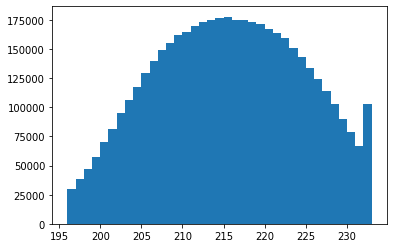

среднее расстояние вставки: 31314.689419364335
среднеквадратичное отклонение: 246217.1786722348
интервал минимальной ширины, в который попадает 95% ридов: (0, 332)
среднее расстояние вставки 95% ридов: 257.33527431850496
среднеквадратичное отклонение 95% ридов: 66.1627964459425


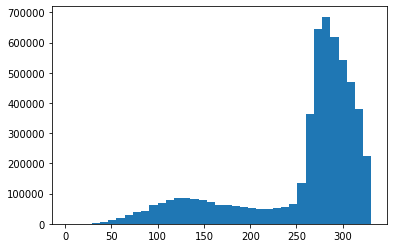

In [16]:
def insert_size(al_path):
    bamfile = pysam.AlignmentFile(al_path, 'rb')
    
    insert_sizes = []
    
    for line in bamfile:
        insert_sizes.append(abs(line.template_length))
    
    insert_sizes = np.array(insert_sizes)
    print('среднее расстояние вставки:', insert_sizes.mean())
    print('среднеквадратичное отклонение:', insert_sizes.std())
    
    insert_sizes.sort()
    width = int(len(insert_sizes) * 0.95) + 1
    
    low = 0
    high = low + width
    min_w = insert_sizes[high] - insert_sizes[low]
    
    for i in range(len(insert_sizes)):
        if i + width >= len(insert_sizes):
            break
        new_w = insert_sizes[i + width] - insert_sizes[i]
        if min_w > new_w:
            min_w = new_w
            low = i
            high = i + width
    
    print('интервал минимальной ширины, в который попадает 95% ридов:',
          (insert_sizes[low], insert_sizes[high]))
    
    insert_sizes_95 = insert_sizes[(insert_sizes > insert_sizes[low]) & (insert_sizes < insert_sizes[high])]
    
    print('среднее расстояние вставки 95% ридов:', insert_sizes_95.mean())
    print('среднеквадратичное отклонение 95% ридов:', insert_sizes_95.std())
    
    
    # строим только 95% интервал чтобы избежать выбросов
    plt.hist(insert_sizes_95, bins=37)
    plt.show()

# запускаем на тестовых данных и двух датасетах
insert_size(f'{data_test_path}alignment.sorted.bam')
insert_size(f'{data_path}alignment1.sorted.bam')
insert_size(f'{data_path}alignment2.sorted.bam')

# 3. Частоты различных замен

In [30]:
def repl_freq(al_path):
    bamfile = pysam.AlignmentFile(al_path, 'rb')
    ref_name = bamfile.get_reference_name(0)
    
    freq = {
        'A': {'A': 0, 'C': 0, 'G': 0, 'T': 0, 'N': 0},
        'C': {'A': 0, 'C': 0, 'G': 0, 'T': 0, 'N': 0},
        'G': {'A': 0, 'C': 0, 'G': 0, 'T': 0, 'N': 0},
        'T': {'A': 0, 'C': 0, 'G': 0, 'T': 0, 'N': 0},
        'N': {'A': 0, 'C': 0, 'G': 0, 'T': 0, 'N': 0}
    }
    
    errors = []
    
    for line in bamfile.fetch(ref_name):
        query_length = line.query_length
        err_num = 0
        try:
            for p in line.get_aligned_pairs(with_seq=True):
                if p[2] in ['a', 'c', 'g', 't', 'n']:
                    freq[line.query_sequence[p[0]]][p[2].upper()] += 1
                    err_num += 1
        except:
            continue
        
        errors.append(err_num / query_length)
    
    print(pd.DataFrame(freq))
    print('avg error:', np.array(errors).mean() * 100, '%')

# запускаем на тестовых данных и двух датасетах
print('test')
repl_freq(f'{data_test_path}alignment.sorted.bam')

print('df1')
repl_freq(f'{data_path}alignment1.sorted.bam')

print('df2')
repl_freq(f'{data_path}alignment2.sorted.bam')

test
   A   C   G   T  N
A  0  15  19   1  0
C  0   0   2   1  0
G  0  21   0  34  0
T  0   0  16   0  0
N  0   0   0   0  0
avg error: 0.002567403486838207 %
df1
        A       C       G       T      N
A       0  637340  380536  145879  84469
C  272766       0  240021  157971  84271
G  159165  241260       0  273569  84532
T  146392  379576  637018       0  84100
N       0       0       0       0      0
avg error: 0.8031547312105539 %
df2
        A       C       G       T       N
A       0  616006  377466  168711  204490
C  282365       0  219045  175047  198160
G  175310  223157       0  277789  196474
T  170488  381076  604303       0  202196
N       0       0       0       0       0
avg error: 0.7860450757245909 %


# 4. Статистика ридов IonTorrent

In [41]:
# test
data_path = 'data/ion/'
df = f'{data_path}test.fastq'
genome_t = f'{data_path}test_reference.fasta'

# prod
df1 = f'{data_path}B22-730.fastq'
df2 = f'{data_path}C24-698.fastq'
genome = f'{data_path}DH10B-K12.fasta'

In [185]:
!bwa index {genome_t}
!bwa index {genome}

[bwa_index] Pack FASTA... 0.05 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 2.10 seconds elapse.
[bwa_index] Update BWT... 0.04 sec
[bwa_index] Pack forward-only FASTA... 0.03 sec
[bwa_index] Construct SA from BWT and Occ... 0.47 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index data/ion/test_reference.fasta
[main] Real time: 2.696 sec; CPU: 2.699 sec
[bwa_index] Pack FASTA... 0.03 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 1.12 seconds elapse.
[bwa_index] Update BWT... 0.03 sec
[bwa_index] Pack forward-only FASTA... 0.02 sec
[bwa_index] Construct SA from BWT and Occ... 0.27 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index data/ion/DH10B-K12.fasta
[main] Real time: 1.476 sec; CPU: 1.482 sec


In [ ]:
!bwa mem {genome_t} {df} > {data_path}alignment.sam
!bwa mem {genome} {df1} > {data_path}alignment1.sam
!bwa mem {genome} {df2} > {data_path}alignment2.sam

In [188]:
!samtools flagstat {data_path}alignment.sam

250 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
0 + 0 mapped (0.00% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


ничего не выровнялось на тестовом, не будем его использовать впоследствии

In [187]:
!samtools flagstat {data_path}alignment1.sam

497384 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
2463 + 0 supplementary
0 + 0 duplicates
489459 + 0 mapped (98.41% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [189]:
!samtools flagstat {data_path}alignment2.sam

686667 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
1261 + 0 supplementary
0 + 0 duplicates
682638 + 0 mapped (99.41% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [190]:
!samtools view -b {data_path}alignment1.sam > {data_path}alignment1.bam
!samtools sort {data_path}alignment1.bam > {data_path}alignment1.sorted.bam
!samtools index {data_path}alignment1.sorted.bam

!samtools view -b {data_path}alignment2.sam > {data_path}alignment2.bam
!samtools sort {data_path}alignment2.bam > {data_path}alignment2.sorted.bam
!samtools index {data_path}alignment2.sorted.bam

Покрытие генома

Доля покрытой области: 99.98796450039767 %
Среднее покрытие: 33.952685975676765


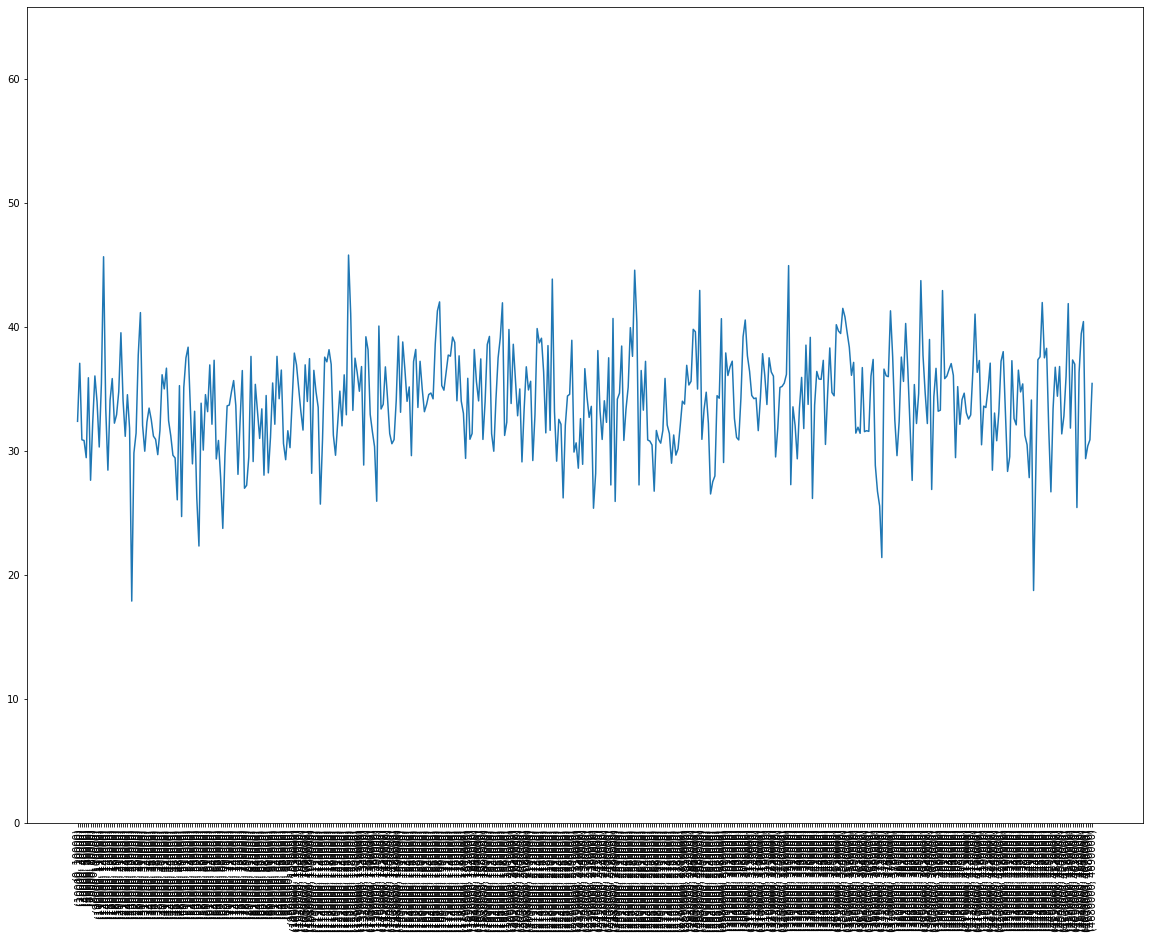

Доля покрытой области: 99.9999786604617 %
Среднее покрытие: 35.65372971383466


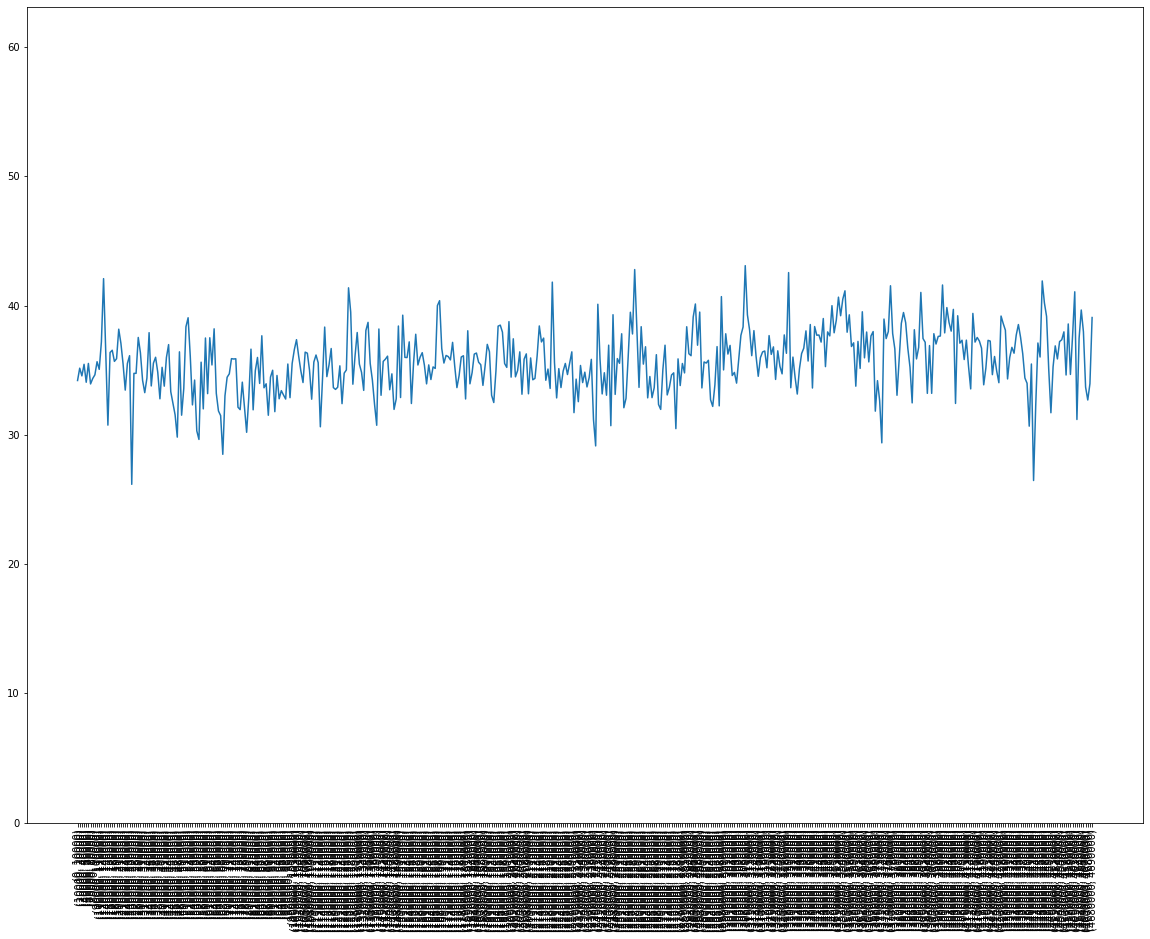

In [42]:
coverage(f'{data_path}alignment1.sorted.bam', avg=10000)
coverage(f'{data_path}alignment2.sorted.bam', avg=10000)

In [113]:
def errors(al_path):
    bamfile = pysam.AlignmentFile(al_path, 'rb')
    ref_name = bamfile.get_reference_name(0)
    
    indel_length = []
    errors = []
    
    freq = {
        'A': {'A': 0, 'C': 0, 'G': 0, 'T': 0, '_': 0},
        'C': {'A': 0, 'C': 0, 'G': 0, 'T': 0, '_': 0},
        'G': {'A': 0, 'C': 0, 'G': 0, 'T': 0, '_': 0},
        'T': {'A': 0, 'C': 0, 'G': 0, 'T': 0, '_': 0},
        '_': {'A': 0, 'C': 0, 'G': 0, 'T': 0, '_': 0}
    }
    
    ins_qual = []
    mismatch_qual = []
        
    for line in bamfile.fetch(ref_name):
        cigar = line.cigartuples
        read_len = line.query_length
        pairs = line.get_aligned_pairs(with_seq=True)
        
        qual = line.query_alignment_qualities
        
        ci = 0
        ciwd = 0
        err = 0
        
        for s in cigar: 
            
            if s[0] == 0: # match/mismatch
                for ip, p in enumerate(pairs[ci:ci + s[1]]):
                    if p[2] in ['a', 'c', 'g', 't']:
                        freq[line.query_sequence[p[0]]][p[2].upper()] += 1
                        err += 1
                        if len(qual) <= ciwd + ip:
                            print(ci, ip, ciwd)
                            print(len(qual))
                            print('pairs', len(pairs))
                            print(read_len)
                            print(cigar)
                        mismatch_qual.append(qual[ciwd + ip])
            elif s[0] == 1: # insertion
                indel_length.append(s[1])
                err += s[1]
                for ip, p in enumerate(pairs[ci:ci + s[1]]):
                    if p[0] is not None:
                        freq[line.query_sequence[p[0]]]['_'] += 1
                        if len(qual) <= ciwd + ip:
                            print(ci, ip, ciwd)
                            print(len(qual))
                            print('pairs', len(pairs))
                            print(read_len)
                            print(cigar)
                        ins_qual.append(qual[ciwd + ip])
                
            elif s[0] == 2: # del
                indel_length.append(s[1])
                err += s[1]
                for p in pairs[ci:ci + s[1]]:
                    if p[2] is not None:
                        freq['_'][p[2].upper()] += 1
            
            ci += s[1]
            if s[0] != 2 and s[0] != 4 and s[0] != 5:
                ciwd += s[1]
        
        errors.append(err / read_len)
        
    print(f'Средний процент ошибок в ридах: {np.mean(errors) * 100}%')
    print('----')
    print(f'Средняя длина индела: {np.mean(indel_length)}')
    print(f'Стандартное отклонение индела: {np.std(indel_length)}')
    print(f'Минимум индела: {np.min(indel_length)}')
    print(f'Максимум индела: {np.max(indel_length)}')
    print('----')
    print(f'Среднее качество нуклеотида при ошибочно вставленном нуклеотиде: {np.mean(ins_qual)}')
    print(f'Стандартное отклонение качества нуклеотида при ошибочно вставленном нуклеотиде: {np.std(ins_qual)}')
    print('----')
    print(f'Среднее качество нуклеотида при замене: {np.mean(mismatch_qual)}')
    print(f'Стандартное отклонение качества нуклеотида при замене: {np.std(mismatch_qual)}')
    print('----')
    print(pd.DataFrame(freq))

print('df1')
errors(f'{data_path}alignment1.sorted.bam')

print('df2')
errors(f'{data_path}alignment2.sorted.bam')

df1
Средний процент ошибок в ридах: 0.7431720068688202%
----
Средняя длина индела: 1.0790305672298803
Стандартное отклонение индела: 0.39446696806164533
Минимум индела: 1
Максимум индела: 24
----
Среднее качество нуклеотида при ошибочно вставленном нуклеотиде: 16.090398405540252
Стандартное отклонение качества нуклеотида при ошибочно вставленном нуклеотиде: 5.875699440319459
----
Среднее качество нуклеотида при замене: 19.144084450267055
Стандартное отклонение качества нуклеотида при замене: 8.035353269922297
----
        A      C      G       T       _
A       0   9140  23635   11150  119093
C   10345      0   8080   16650   72392
G   17191   7200      0   10557   72695
T   11305  24468   9047       0  119220
_  182928  78967  79104  184320       0
df2
Средний процент ошибок в ридах: 0.4096696207779137%
----
Средняя длина индела: 1.0678876152719123
Стандартное отклонение индела: 0.3357167843960168
Минимум индела: 1
Максимум индела: 26
----
Среднее качество нуклеотида при ошибочно вста